### Sujet du TP : **Analyse  d'une base de données sur les ventes de produits agricoles**

#### Contexte :  
Un service de suivi des ventes agricoles souhaite  analyser sa base de données. Les données brutes sont stockées dans PostgreSQL, mais pour des analyses approfondies et semi-structurées, MongoDB est utilisé.

---

### Scénario :  

1. **Base relationnelle (PostgreSQL)** :  
   - Table `produits` : id_produit, nom, catégorie, prix_unitaire.  
   - Table `ventes` : id_vente, id_produit, quantité, date_vente, region_vente.  
   - Table `regions` : id_region, nom_region, population.  

2. **Base NoSQL (MongoDB)** :  
   - Collection `ventes_agrégées` :  
     - Données agrégées par mois, région, et catégorie de produit.    

---

### Activités principales :  
---

In [1]:
!pip install seaborn 
!pip install matplotlib
!pip install scikit-learn
!pip install sqlalchemy


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# TP : Analyse et Enrichissement des Ventes de Produits Agricoles
import os
import pandas as pd
import numpy as np
import sqlalchemy as sa
import pymongo
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker
from datetime import datetime, timedelta
import random
from sqlalchemy import Column, Integer, String, Numeric, Date, ForeignKey, UUID
from sqlalchemy.orm import declarative_base
import uuid
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import TruncatedSVD, PCA
from sqlalchemy import func, extract

In [3]:
# Configuration des bases de données
POSTGRES_CONFIG = {
    'host': 'postgres_container',
    'database': 'mydb',
    'user': 'admin',
    'password': 'admin'
}

MONGODB_CONFIG = {
    'host': 'mongo_container',
    'port': 27017,
    'database': 'agricultural_sales_db',
    'username': 'admin',
    'password': 'admin'
}

Base = declarative_base()

class Region(Base):
    __tablename__ = 'regions'
    id = Column(Integer, primary_key=True, autoincrement=True)
    nom_region = Column(String(100), nullable=False)
    population = Column(Integer)
    superficie = Column(Numeric(10, 2))
    type_agriculture = Column(String(50))

class Produit(Base):
    __tablename__ = 'produits'
    id = Column(Integer, primary_key=True, autoincrement=True)
    nom = Column(String(100), nullable=False)
    categorie = Column(String(50), nullable=False)
    prix_unitaire = Column(Numeric(10, 2), nullable=False)
    unite_mesure = Column(String(20))
    saison_production = Column(String(50))

class Vente(Base):
    __tablename__ = 'ventes'
    id = Column(Integer, primary_key=True, autoincrement=True)
    id_produit = Column(Integer, ForeignKey('produits.id'))
    quantite = Column(Numeric(10, 2), nullable=False)
    date_vente = Column(Date, nullable=False)
    id_region = Column(Integer, ForeignKey('regions.id'))
    prix_total = Column(Numeric(10, 2))
    type_client = Column(String(50))


In [4]:
# Connexion à PostgreSQL
def connect_postgres():
    """Établit une connexion à PostgreSQL"""
    connection_string = (
        f"postgresql+psycopg2://{POSTGRES_CONFIG['user']}:"
        f"{POSTGRES_CONFIG['password']}@{POSTGRES_CONFIG['host']}/"
        f"{POSTGRES_CONFIG['database']}"
    )
    try:
        engine = create_engine(connection_string)
        # Test de connexion
        with engine.connect() as connection:
            print("Connexion à PostgreSQL réussie")
        return engine
    except Exception as e:
        print(f"Erreur de connexion : {e}")
        return None

# Exécution du test de connexion
postgres_engine = connect_postgres()
# Supprimer les anciennes tables
Base.metadata.drop_all(postgres_engine)
Base.metadata.create_all(postgres_engine)

Connexion à PostgreSQL réussie


In [5]:
def generer_donnees_test():
    # Régions$$
    regions = [
        {'nom_region': 'Kara', 'population': 1830000, 'superficie': 9000, 'type_agriculture': 'Élevage'},
        {'nom_region': 'Savanes', 'population': 155000, 'superficie': 6200, 'type_agriculture': 'Céréalière'},
        {'nom_region': 'Maritime', 'population': 3700000, 'superficie': 11000, 'type_agriculture': 'Maraîchage'},
        {'nom_region': 'Plateaux', 'population': 1500000, 'superficie': 8500, 'type_agriculture': 'Cultures vivrières'},
        {'nom_region': 'Centrale', 'population': 1200000, 'superficie': 6000, 'type_agriculture': 'Élevage et cultures'}
    ]

    # Produits agricoles
    categories_produits = [
        {'nom': 'Maïs', 'categorie': 'Céréales', 'prix_unitaire': 0.20, 'unite_mesure': 'tonne', 'saison_production': 'Automne'},
        {'nom': 'Riz', 'categorie': 'Céréales', 'prix_unitaire': 0.25, 'unite_mesure': 'tonne', 'saison_production': 'Toute l\'année'},
        {'nom': 'Mil', 'categorie': 'Céréales', 'prix_unitaire': 0.18, 'unite_mesure': 'tonne', 'saison_production': 'Été'},
        {'nom': 'Yams', 'categorie': 'Tubercules', 'prix_unitaire': 0.50, 'unite_mesure': 'kg', 'saison_production': 'Automne'},
        {'nom': 'Piments', 'categorie': 'Légumes', 'prix_unitaire': 0.60, 'unite_mesure': 'kg', 'saison_production': 'Toute l\'année'},
        {'nom': 'Tomates', 'categorie': 'Légumes', 'prix_unitaire': 0.40, 'unite_mesure': 'kg', 'saison_production': 'Automne'},
        {'nom': 'Mangues', 'categorie': 'Fruits', 'prix_unitaire': 0.80, 'unite_mesure': 'kg', 'saison_production': 'Automne'},
        {'nom': 'Papayes', 'categorie': 'Fruits', 'prix_unitaire': 1.00, 'unite_mesure': 'kg', 'saison_production': 'Toute l\'année'},
        {'nom': 'Arachides', 'categorie': 'Oléagineux', 'prix_unitaire': 0.35, 'unite_mesure': 'tonne', 'saison_production': 'Automne'}
    ]

    # Types de clients
    types_clients = [
        'Grossiste', 'Détaillant', 'Coopérative', 'Transformation industrielle', 
        'Exportation', 'Marché local', 'Grande distribution'
    ]

    # Génération de ventes
    ventes = []
    date_debut = datetime(2022, 1, 1)
    date_fin = datetime(2023, 12, 31)

    quantites_realistes = {
        'tonne': (0.5, 500),  
        'kg': (1, 1000)  
    }

    # Nombre de ventes par région
    nombre_ventes_par_region = 250
    
    # Distribution équilibrée des types de clients
    client_distribution = np.tile(types_clients, nombre_ventes_par_region // len(types_clients))

    # Distribution équilibrée des catégories de produits
    categories_distribution = np.tile([produit['categorie'] for produit in categories_produits], nombre_ventes_par_region // len(categories_produits))

    # Générer les ventes
    for region_id, region in enumerate(regions, 1):
        for client_type, produit_category in zip(client_distribution, categories_distribution):
            # Sélectionner un produit dans la catégorie
            produit = random.choice([p for p in categories_produits if p['categorie'] == produit_category])
            
            date_vente = date_debut + timedelta(
                days=random.randint(0, (date_fin - date_debut).days)
            )
            
            # Générer la quantité
            if 'tonne' in produit['unite_mesure']:
                quantite = round(random.uniform(*quantites_realistes['tonne']), 2)
            else:
                quantite = round(random.uniform(*quantites_realistes['kg']), 2)
            
            # Calcul du prix total
            prix_total = round(quantite * produit['prix_unitaire'], 2)
            
            # Créer la vente
            vente = {
                'id_produit': categories_produits.index(produit) + 1,
                'quantite': quantite,
                'date_vente': date_vente,
                'id_region': region_id,
                'prix_total': prix_total,
                'type_client': client_type
            }
            ventes.append(vente)

    return {
        'regions': regions,
        'produits': categories_produits,
        'ventes': ventes
    }


In [6]:
# Configuration
def configurer_base_de_donnees(engine):
    """
    Configure la base de données PostgreSQL pour le TP
    - Crée les tables
    - Insère des données de test via l'ORM SQLAlchemy
    """

    try:
        # Génération des données
        donnees = generer_donnees_test()

        # Crée une session pour l'insertion des données
        Session = sessionmaker(bind=engine)
        session = Session()

        # Insertion des données pour les régions
        for region_data in donnees['regions']:
            region = Region(
                nom_region=region_data['nom_region'],
                population=region_data['population'],
                superficie=region_data['superficie'],
                type_agriculture=region_data['type_agriculture']
            )
            session.add(region)

        # Insertion des données pour les produits
        for produit_data in donnees['produits']:
            produit = Produit(
                nom=produit_data['nom'],
                categorie=produit_data['categorie'],
                prix_unitaire=produit_data['prix_unitaire'],
                unite_mesure=produit_data['unite_mesure'],
                saison_production=produit_data['saison_production']
            )
            session.add(produit)

        # Insertion des données pour les ventes
        for vente_data in donnees['ventes']:
            vente = Vente(
                id_produit=vente_data['id_produit'],
                quantite=vente_data['quantite'],
                date_vente=vente_data['date_vente'],
                id_region=vente_data['id_region'],
                prix_total=vente_data['prix_total'],
                type_client=vente_data['type_client']
            )
            session.add(vente)

        # Commit des changements dans la base de données
        session.commit()
        print("Données de test insérées avec succès via l'ORM")

        # Vérification des données
        with engine.connect() as connection:
            print("\nRésumé des données :")
            for table in ['regions', 'produits', 'ventes']:
                result = connection.execute(text(f"SELECT COUNT(*) FROM {table}")).scalar()
                print(f"{table.capitalize()} : {result} enregistrements")

        # Fermeture de la session
        session.close()

    except Exception as e:
        print(f"Erreur lors de la configuration : {e}")

configurer_base_de_donnees(postgres_engine)

Données de test insérées avec succès via l'ORM

Résumé des données :
Regions : 5 enregistrements
Produits : 9 enregistrements
Ventes : 1215 enregistrements


In [7]:
def revenus_moyens_par_produit(session):
    """
    Calcule les revenus moyens par produit pour chaque type de client.

    SQL Equivalent:
    SELECT 
        p.nom AS produit, 
        v.type_client, 
        AVG(v.prix_total) AS revenu_moyen
    FROM ventes v
    JOIN produits p ON v.id_produit = p.id
    GROUP BY p.nom, v.type_client
    ORDER BY produit, type_client;
    """
    result = session.query(
        Produit.nom,
        Vente.type_client,
        func.avg(Vente.prix_total).label('revenu_moyen')
    ).join(Vente, Vente.id_produit == Produit.id).group_by(Produit.nom, Vente.type_client).order_by(Produit.nom, Vente.type_client).all()

    for row in result:
        print(row)


def ventes_par_periode(session):
    """
    Identifie les périodes de l'année où chaque catégorie de produit est la plus vendue.

    SQL Equivalent:
    SELECT 
        p.categorie,
        EXTRACT(MONTH FROM v.date_vente) AS mois,
        SUM(v.quantite) AS quantite_totale
    FROM ventes v
    JOIN produits p ON v.id_produit = p.id
    GROUP BY p.categorie, mois
    ORDER BY p.categorie, mois;
    """
    result = session.query(
        Produit.categorie,
        extract('month', Vente.date_vente).label('mois'),
        func.sum(Vente.quantite).label('quantite_totale')
    ).join(Vente, Vente.id_produit == Produit.id).group_by(Produit.categorie, 'mois').order_by(Produit.categorie, 'mois').all()

    for row in result:
        print(row)

def correlation_population_ventes(session):
    """
    Analyse la corrélation entre la population et les ventes totales d'une région.

    SQL Equivalent:
    SELECT 
        r.nom_region,
        r.population,
        SUM(v.prix_total) AS ventes_totales
    FROM regions r
    JOIN ventes v ON r.id = v.id_region
    GROUP BY r.nom_region, r.population
    ORDER BY r.nom_region;
    """
    result = session.query(
        Region.nom_region,
        Region.population,
        func.sum(Vente.prix_total).label('ventes_totales')
    ).join(Vente, Vente.id_region == Region.id).group_by(Region.nom_region, Region.population).order_by(Region.nom_region).all()

    for row in result:
        print(row)


Session = sessionmaker(bind=postgres_engine)
session = Session()

In [8]:
revenus_moyens_par_produit(session)

('Arachides', 'Coopérative', Decimal('90.1615000000000000'))
('Arachides', 'Détaillant', Decimal('73.9625000000000000'))
('Arachides', 'Exportation', Decimal('83.8655000000000000'))
('Arachides', 'Grande distribution', Decimal('79.2073333333333333'))
('Arachides', 'Grossiste', Decimal('84.5310000000000000'))
('Arachides', 'Marché local', Decimal('86.6540000000000000'))
('Arachides', 'Transformation industrielle', Decimal('97.2680000000000000'))
('Maïs', 'Coopérative', Decimal('39.3720000000000000'))
('Maïs', 'Détaillant', Decimal('60.4343478260869565'))
('Maïs', 'Exportation', Decimal('50.3866666666666667'))
('Maïs', 'Grande distribution', Decimal('46.8905882352941176'))
('Maïs', 'Grossiste', Decimal('46.9958823529411765'))
('Maïs', 'Marché local', Decimal('44.1875000000000000'))
('Maïs', 'Transformation industrielle', Decimal('51.9765000000000000'))
('Mangues', 'Coopérative', Decimal('409.1178947368421053'))
('Mangues', 'Détaillant', Decimal('385.6104347826086957'))
('Mangues', 'Expor

In [9]:
ventes_par_periode(session)

('Céréales', Decimal('1'), Decimal('7447.76'))
('Céréales', Decimal('2'), Decimal('7620.91'))
('Céréales', Decimal('3'), Decimal('9721.19'))
('Céréales', Decimal('4'), Decimal('6471.02'))
('Céréales', Decimal('5'), Decimal('8758.88'))
('Céréales', Decimal('6'), Decimal('8561.44'))
('Céréales', Decimal('7'), Decimal('7819.89'))
('Céréales', Decimal('8'), Decimal('8680.15'))
('Céréales', Decimal('9'), Decimal('6486.31'))
('Céréales', Decimal('10'), Decimal('9234.92'))
('Céréales', Decimal('11'), Decimal('11972.63'))
('Céréales', Decimal('12'), Decimal('7570.28'))
('Fruits', Decimal('1'), Decimal('8737.66'))
('Fruits', Decimal('2'), Decimal('14658.49'))
('Fruits', Decimal('3'), Decimal('9659.88'))
('Fruits', Decimal('4'), Decimal('10988.14'))
('Fruits', Decimal('5'), Decimal('14771.70'))
('Fruits', Decimal('6'), Decimal('6391.26'))
('Fruits', Decimal('7'), Decimal('15601.19'))
('Fruits', Decimal('8'), Decimal('8336.98'))
('Fruits', Decimal('9'), Decimal('12489.54'))
('Fruits', Decimal('10

In [10]:
correlation_population_ventes(session)

('Centrale', 1200000, Decimal('50693.12'))
('Kara', 1830000, Decimal('52130.82'))
('Maritime', 3700000, Decimal('51072.91'))
('Plateaux', 1500000, Decimal('54458.06'))
('Savanes', 155000, Decimal('52626.39'))


In [11]:
def extraire_donnees_ventes(engine):
    """Extraction des données de vente avec jointures"""
    requete_sql = """
    SELECT 
        v.id,
        p.nom AS nom_produit,
        p.categorie,
        p.prix_unitaire,
        v.quantite,
        v.date_vente,
        r.nom_region,
        r.population
    FROM 
        ventes v
    JOIN 
        produits p ON v.id_produit = p.id
    JOIN 
        regions r ON v.id_region = r.id
    """
    try:
        df_ventes = pd.read_sql(requete_sql, engine)
        print("Extraction des données réussie")
        print(f"Nombre de lignes : {len(df_ventes)}")
        print("\nAperçu des données :")
        print(df_ventes.head())
        
        # Informations sur le DataFrame
        print("\nInformations sur le DataFrame :")
        df_ventes.info()
        
        return df_ventes
    except Exception as e:
        print(f"Erreur lors de l'extraction : {e}")
        return None

# Extraction des données
df_ventes = extraire_donnees_ventes(postgres_engine)

Extraction des données réussie
Nombre de lignes : 1215

Aperçu des données :
   id nom_produit   categorie  prix_unitaire  quantite  date_vente nom_region  \
0   1         Mil    Céréales           0.18    156.89  2022-04-08       Kara   
1   2        Maïs    Céréales           0.20    164.11  2022-02-19       Kara   
2   3        Maïs    Céréales           0.20     52.53  2022-10-30       Kara   
3   4        Yams  Tubercules           0.50    842.46  2023-10-17       Kara   
4   5     Tomates     Légumes           0.40    971.98  2022-04-30       Kara   

   population  
0     1830000  
1     1830000  
2     1830000  
3     1830000  
4     1830000  

Informations sur le DataFrame :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1215 entries, 0 to 1214
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1215 non-null   int64  
 1   nom_produit    1215 non-null   object 
 2   categorie      1215 

Analyse descriptive des ventes :

1. Statistiques globales :
                id  prix_unitaire     quantite    population
count  1215.000000    1215.000000  1215.000000  1.215000e+03
mean    608.000000       0.477975   392.320576  1.677000e+06
std     350.884596       0.266333   268.259006  1.157307e+06
min       1.000000       0.180000     0.680000  1.550000e+05
25%     304.500000       0.250000   184.155000  1.200000e+06
50%     608.000000       0.400000   346.540000  1.500000e+06
75%     911.500000       0.600000   544.510000  1.830000e+06
max    1215.000000       1.000000   997.010000  3.700000e+06

2. Ventes totales par région (en termes de prix) :
nom_region
Plateaux    54458.1165
Savanes     52626.3720
Kara        52130.7854
Maritime    51072.8954
Centrale    50693.0951
Name: prix_total, dtype: float64

3. Ventes totales par catégorie (en termes de prix) :
categorie
Fruits        124038.5860
Légumes        70612.5640
Tubercules     33478.2850
Céréales       21334.8274
Oléagineux

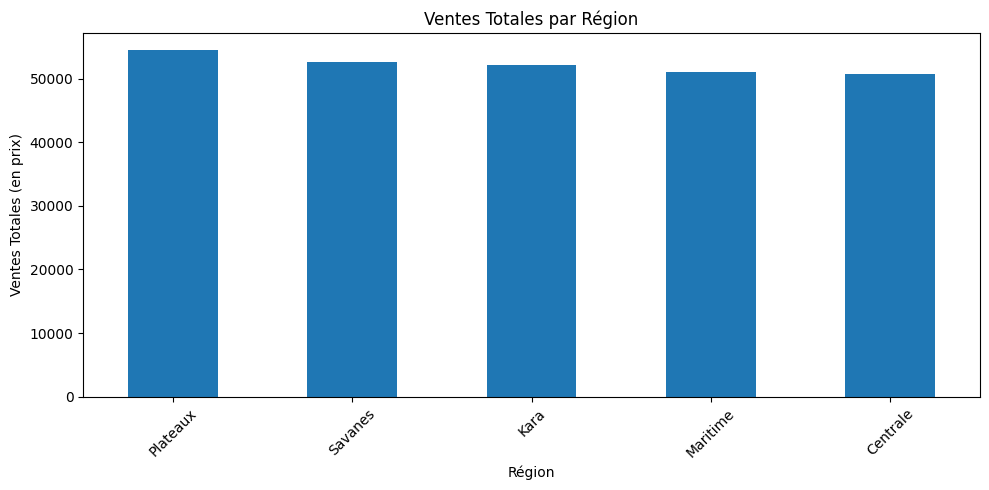

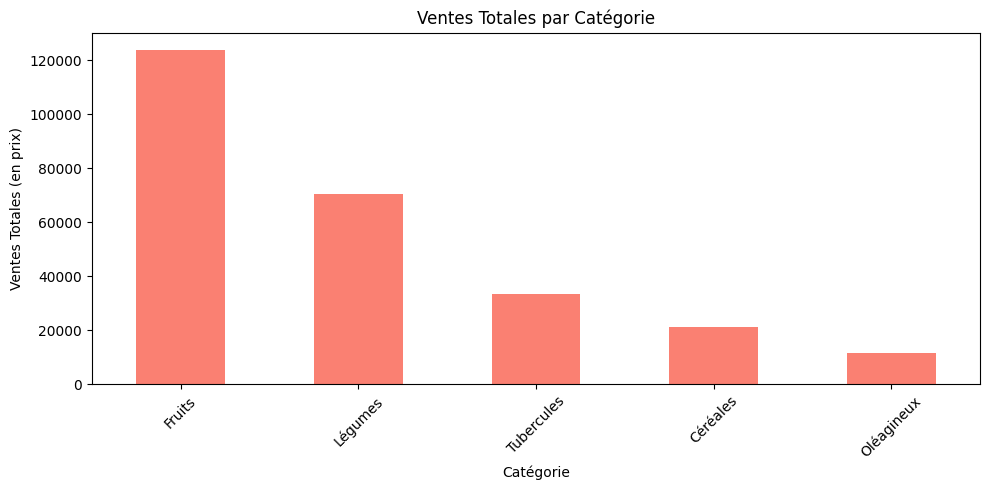

In [12]:
def analyse_descriptive(df):
    """Analyse descriptive des ventes en tenant compte du prix total des ventes"""
    print("Analyse descriptive des ventes :")
    
    # Statistiques globales
    print("\n1. Statistiques globales :")
    print(df.describe())
    
    # Calcul du prix total des ventes
    df['prix_total'] = df['quantite'] * df['prix_unitaire']
    
    # Ventes totales par région (en termes de prix total)
    print("\n2. Ventes totales par région (en termes de prix) :")
    ventes_par_region = df.groupby('nom_region')['prix_total'].sum().sort_values(ascending=False)
    print(ventes_par_region)
    
    # Ventes totales par catégorie (en termes de prix total)
    print("\n3. Ventes totales par catégorie (en termes de prix) :")
    ventes_par_categorie = df.groupby('categorie')['prix_total'].sum().sort_values(ascending=False)
    print(ventes_par_categorie)
    
    # Visualisation des ventes totales par région
    plt.figure(figsize=(10, 5))
    ventes_par_region.plot(kind='bar')
    plt.title('Ventes Totales par Région')
    plt.xlabel('Région')
    plt.ylabel('Ventes Totales (en prix)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Visualisation des ventes totales par catégorie
    plt.figure(figsize=(10, 5))
    ventes_par_categorie.plot(kind='bar', color='salmon')
    plt.title('Ventes Totales par Catégorie')
    plt.xlabel('Catégorie')
    plt.ylabel('Ventes Totales (en prix)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return ventes_par_region, ventes_par_categorie

# Analyse descriptive
if df_ventes is not None:
    ventes_region, ventes_categorie = analyse_descriptive(df_ventes)

In [13]:
def charger_mongodb(donnees):
    """Chargement des données dans MongoDB avec conversion des dates au format ISO."""
    try:
        # Connexion au client MongoDB
        client = pymongo.MongoClient(
            host=MONGODB_CONFIG['host'], 
            port=MONGODB_CONFIG['port'],
            username= "admin",
            password="admin"
        )
        db = client[MONGODB_CONFIG['database']]
        
        # Collection des ventes
        collection_ventes = db['ventes_agricoles']

        # Suppression de la colonne 'id' si elle existe
        if 'id' in donnees.columns:
            donnees = donnees.drop(columns=["id"])
        
        # Conversion des colonnes de type datetime.date en ISO 8601
        donnees["date_vente"] = donnees["date_vente"].apply(lambda x: x.isoformat())
        # Conversion des données en format compatible MongoDB
        donnees_json = donnees.to_dict('records')
        
        # Insertion dans MongoDB
        result = collection_ventes.insert_many(donnees_json)
        
        print("Données chargées dans MongoDB")
        print(f"Nombre de documents insérés : {len(result.inserted_ids)}")
        
        return collection_ventes
    except Exception as e:
        print(f"Erreur de chargement dans MongoDB : {e}")
        return None

if 'df_ventes' in locals():
    collection_mongodb = charger_mongodb(df_ventes)
df_ventes

Données chargées dans MongoDB
Nombre de documents insérés : 1215


,id,nom_produit,categorie,prix_unitaire,quantite,date_vente,nom_region,population,prix_total
0,1,Mil,Céréales,0.18,156.89,2022-04-08,Kara,1830000,28.2402
1,2,Maïs,Céréales,0.20,164.11,2022-02-19,Kara,1830000,32.8220
2,3,Maïs,Céréales,0.20,52.53,2022-10-30,Kara,1830000,10.5060
3,4,Yams,Tubercules,0.50,842.46,2023-10-17,Kara,1830000,421.2300
4,5,Tomates,Légumes,0.40,971.98,2022-04-30,Kara,1830000,388.7920
...,...,...,...,...,...,...,...,...,...
1210,1211,Piments,Légumes,0.60,942.15,2022-05-11,Centrale,1200000,565.2900
1211,1212,Tomates,Légumes,0.40,859.59,2023-11-03,Centrale,1200000,343.8360
1212,1213,Mangues,Fruits,0.80,798.99,2022-02-07,Centrale,1200000,639.1920
1213,1214,Papayes,Fruits,1.00,78.54,2022-06-03,Centrale,1200000,78.5400


Nombre total de documents dans la collection : 1215

Ventes par produit :
Produit : Maïs, Quantité totale : 32890.59, Revenu total : 6578.118
Produit : Piments, Quantité totale : 75195.24, Revenu total : 45117.144
Produit : Riz, Quantité totale : 37354.96, Revenu total : 9338.74
Produit : Papayes, Quantité totale : 70080.77, Revenu total : 70080.77
Produit : Mangues, Quantité totale : 67447.27, Revenu total : 53957.816000000006
Produit : Tomates, Quantité totale : 63738.55, Revenu total : 25495.420000000002
Produit : Arachides, Quantité totale : 32905.72, Revenu total : 11517.001999999999
Produit : Yams, Quantité totale : 66956.57, Revenu total : 33478.285
Produit : Mil, Quantité totale : 30099.83, Revenu total : 5417.9694

Ventes par région :
Région : Maritime, Quantité totale : 91862.9, Revenu total : 51072.8954
Région : Plateaux, Quantité totale : 100850.09, Revenu total : 54458.116500000004
Région : Savanes, Quantité totale : 97716.09, Revenu total : 52626.372
Région : Centrale, Qu

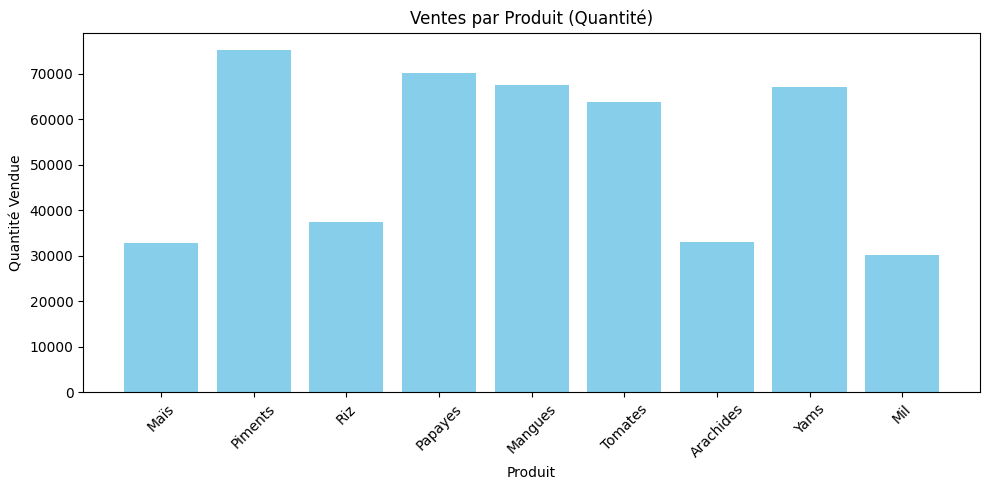

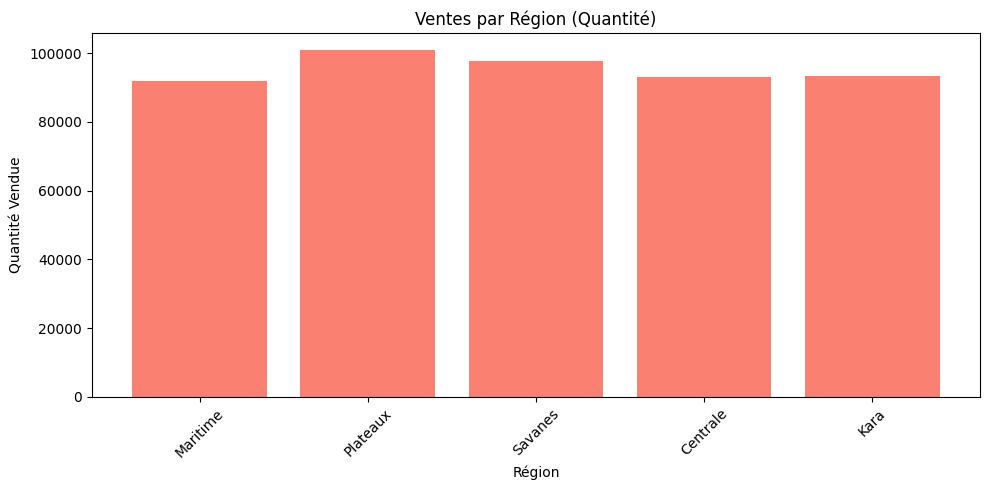


Ventes par mois :
Mois : 2022-06, Quantité totale : 15719.6, Revenu total : 7596.7526
Mois : 2023-03, Quantité totale : 22218.2, Revenu total : 11387.3132
Mois : 2023-01, Quantité totale : 19528.16, Revenu total : 10144.0281
Mois : 2023-04, Quantité totale : 18850.13, Revenu total : 10884.4732
Mois : 2022-09, Quantité totale : 19301.54, Revenu total : 11021.3928
Mois : 2023-08, Quantité totale : 17639.98, Revenu total : 7975.4079
Mois : 2023-02, Quantité totale : 23114.79, Revenu total : 14069.0713
Mois : 2022-05, Quantité totale : 25977.47, Revenu total : 15161.7717
Mois : 2023-09, Quantité totale : 20198.32, Revenu total : 12766.1113
Mois : 2022-01, Quantité totale : 23050.52, Revenu total : 11315.9585
Mois : 2023-10, Quantité totale : 15805.59, Revenu total : 7982.8367
Mois : 2023-12, Quantité totale : 18901.37, Revenu total : 11694.7877
Mois : 2022-03, Quantité totale : 17677.27, Revenu total : 9056.5085
Mois : 2023-05, Quantité totale : 21434.6, Revenu total : 11791.1554
Mois : 2

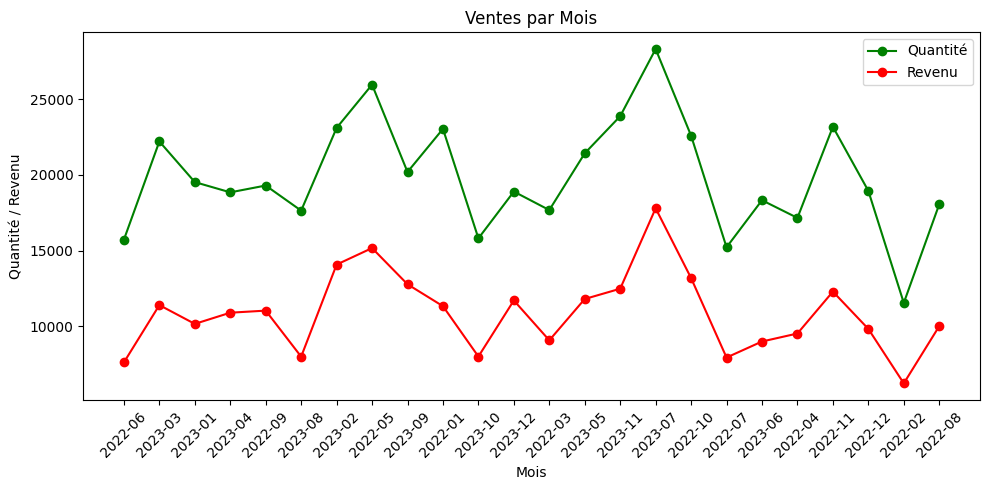


Top 3 des produits les plus vendus (par quantité) :
Produit : Piments, Quantité totale : 75195.24
Produit : Papayes, Quantité totale : 70080.77
Produit : Mangues, Quantité totale : 67447.27


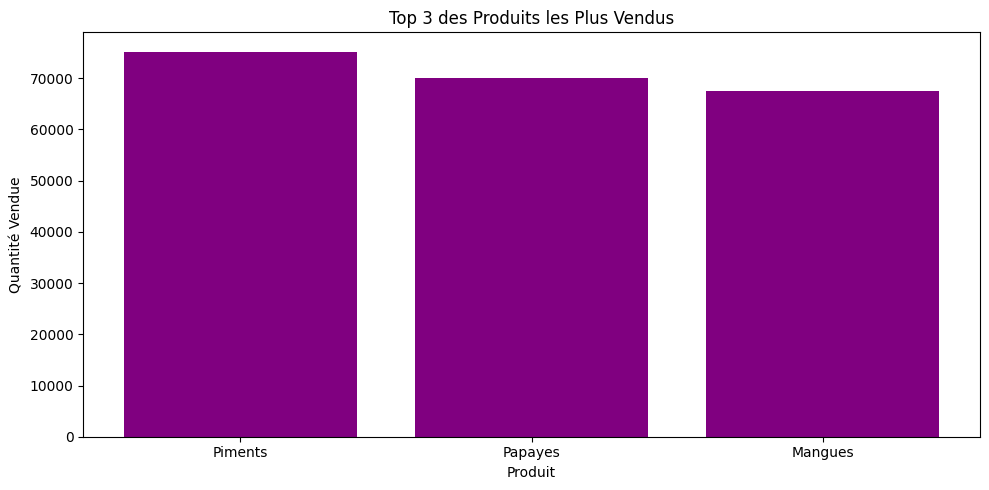


Ventes par saison (Hiver/Été) :
Produit : Arachides, Saison : Autre, Quantité totale : 14465.08, Revenu total : 5062.777999999999
Produit : Arachides, Saison : Hiver, Quantité totale : 9488.29, Revenu total : 3320.9015
Produit : Arachides, Saison : Été, Quantité totale : 8952.35, Revenu total : 3133.3224999999998
Produit : Mangues, Saison : Autre, Quantité totale : 32788.89, Revenu total : 26231.112
Produit : Mangues, Saison : Hiver, Quantité totale : 18964.51, Revenu total : 15171.608
Produit : Mangues, Saison : Été, Quantité totale : 15693.87, Revenu total : 12555.096000000001
Produit : Maïs, Saison : Autre, Quantité totale : 19171.18, Revenu total : 3834.2360000000003
Produit : Maïs, Saison : Hiver, Quantité totale : 5585.41, Revenu total : 1117.082
Produit : Maïs, Saison : Été, Quantité totale : 8134.0, Revenu total : 1626.8000000000002
Produit : Mil, Saison : Autre, Quantité totale : 14382.03, Revenu total : 2588.7653999999998
Produit : Mil, Saison : Hiver, Quantité totale : 7851

In [26]:
import matplotlib.pyplot as plt
from pymongo import MongoClient

def requetes_mongodb(collection):
    try:
        # Nombre total de documents
        total_documents = collection.count_documents({})
        print(f"Nombre total de documents dans la collection : {total_documents}")
        
        # Ventes par produit (calcul du revenu total)
        ventes_par_produit = list(collection.aggregate([
            {"$group": {"_id": "$nom_produit", 
                        "total_quantite": {"$sum": "$quantite"}, 
                        "total_revenu": {"$sum": {"$multiply": ["$quantite", "$prix_unitaire"]}}}}
        ]))
        print("\nVentes par produit :")
        for produit in ventes_par_produit:
            print(f"Produit : {produit['_id']}, Quantité totale : {produit['total_quantite']}, Revenu total : {produit['total_revenu']}")
        
        # Ventes par région
        ventes_par_region = list(collection.aggregate([
            {"$group": {"_id": "$nom_region", 
                        "total_quantite": {"$sum": "$quantite"}, 
                        "total_revenu": {"$sum": {"$multiply": ["$quantite", "$prix_unitaire"]}}}}
        ]))
        print("\nVentes par région :")
        for region in ventes_par_region:
            print(f"Région : {region['_id']}, Quantité totale : {region['total_quantite']}, Revenu total : {region['total_revenu']}")
        
        # Visualisation des ventes par produit
        produits = [produit['_id'] for produit in ventes_par_produit]
        quantites_produit = [produit['total_quantite'] for produit in ventes_par_produit]
        revenus_produit = [produit['total_revenu'] for produit in ventes_par_produit]
        
        plt.figure(figsize=(10, 5))
        plt.bar(produits, quantites_produit, color='skyblue')
        plt.title('Ventes par Produit (Quantité)')
        plt.xlabel('Produit')
        plt.ylabel('Quantité Vendue')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Visualisation des ventes par région
        regions = [region['_id'] for region in ventes_par_region]
        quantites_region = [region['total_quantite'] for region in ventes_par_region]
        revenus_region = [region['total_revenu'] for region in ventes_par_region]
        
        plt.figure(figsize=(10, 5))
        plt.bar(regions, quantites_region, color='salmon')
        plt.title('Ventes par Région (Quantité)')
        plt.xlabel('Région')
        plt.ylabel('Quantité Vendue')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Ventes par mois
        ventes_par_mois = list(collection.aggregate([
            {"$project": {"mois": {"$substr": ["$date_vente", 0, 7]}, "quantite": 1, "prix_unitaire": 1}},
            {"$group": {"_id": "$mois", 
                        "total_quantite": {"$sum": "$quantite"}, 
                        "total_revenu": {"$sum": {"$multiply": ["$quantite", "$prix_unitaire"]}}}}
        ]))
        print("\nVentes par mois :")
        for mois in ventes_par_mois:
            print(f"Mois : {mois['_id']}, Quantité totale : {mois['total_quantite']}, Revenu total : {mois['total_revenu']}")
        
        mois = [mois['_id'] for mois in ventes_par_mois]
        quantites_mois = [mois['total_quantite'] for mois in ventes_par_mois]
        revenus_mois = [mois['total_revenu'] for mois in ventes_par_mois]

        plt.figure(figsize=(10, 5))
        plt.plot(mois, quantites_mois, marker='o', color='green', label='Quantité')
        plt.plot(mois, revenus_mois, marker='o', color='red', label='Revenu')
        plt.title('Ventes par Mois')
        plt.xlabel('Mois')
        plt.ylabel('Quantité / Revenu')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Top 3 des produits les plus vendus par quantité
        top_produits = list(collection.aggregate([
            {"$group": {"_id": "$nom_produit", "total_quantite": {"$sum": "$quantite"}}},
            {"$sort": {"total_quantite": -1}},
            {"$limit": 3}
        ]))
        print("\nTop 3 des produits les plus vendus (par quantité) :")
        for produit in top_produits:
            print(f"Produit : {produit['_id']}, Quantité totale : {produit['total_quantite']}")
        
        produits_top = [produit['_id'] for produit in top_produits]
        quantites_top = [produit['total_quantite'] for produit in top_produits]

        plt.figure(figsize=(10, 5))
        plt.bar(produits_top, quantites_top, color='purple')
        plt.title('Top 3 des Produits les Plus Vendus')
        plt.xlabel('Produit')
        plt.ylabel('Quantité Vendue')
        plt.tight_layout()
        plt.show()

        # Comparaison des ventes par saison
        ventes_par_saison = collection.aggregate([
            {"$project": {
                "nom_produit": 1, 
                "quantite": 1, 
                "prix_unitaire": 1, 
                "mois": {"$substr": ["$date_vente", 5, 2]}},  # Extraire le mois
            },
            {"$project": {
                "nom_produit": 1, 
                "quantite": 1, 
                "prix_unitaire": 1,
                "saison": {
                    "$cond": {
                        "if": {"$in": ["$mois", ["12", "01", "02"]]}, 
                        "then": "Hiver", 
                        "else": {
                            "$cond": {
                                "if": {"$in": ["$mois", ["06", "07", "08"]]}, 
                                "then": "Été", 
                                "else": "Autre"
                            }
                        }
                    }
                }
            }},
            {"$group": {"_id": {"produit": "$nom_produit", "saison": "$saison"}, 
                        "total_quantite": {"$sum": "$quantite"}, 
                        "total_revenu": {"$sum": {"$multiply": ["$quantite", "$prix_unitaire"]}}}},
            {"$sort": {"_id.produit": 1, "_id.saison": 1}}
        ])

        print("\nVentes par saison (Hiver/Été) :")
        for saison in ventes_par_saison:
            print(f"Produit : {saison['_id']['produit']}, Saison : {saison['_id']['saison']}, Quantité totale : {saison['total_quantite']}, Revenu total : {saison['total_revenu']}")

    except Exception as e:
        print(f"Erreur lors de l'exécution des requêtes : {e}")

# Assurez-vous que la collection MongoDB est définie et connectée avant d'exécuter la fonction
if 'collection_mongodb' in locals():
    requetes_mongodb(collection_mongodb)


In [19]:
def preparer_donnees(df):
    # Conversion de la date
    df['date'] = pd.to_datetime(df['date_vente'])
    
    # Extraction des caractéristiques temporelles
    df['mois'] = df['date'].dt.month
    df['jour_semaine'] = df['date'].dt.dayofweek
    
    # Encodage des variables catégorielles
    df = df.drop(columns=[ 'nom_region'])
    df_encoded = pd.get_dummies(df, columns=['nom_produit', 'categorie'])
    
    print("\nNouvelles colonnes :")
    print(df_encoded.columns)
    
    return df_encoded

df_ml = preparer_donnees(df_ventes)
df_ml.head()


Nouvelles colonnes :
Index(['id', 'prix_unitaire', 'quantite', 'date_vente', 'population',
       'prix_total', 'date', 'mois', 'jour_semaine', 'nom_produit_Arachides',
       'nom_produit_Mangues', 'nom_produit_Maïs', 'nom_produit_Mil',
       'nom_produit_Papayes', 'nom_produit_Piments', 'nom_produit_Riz',
       'nom_produit_Tomates', 'nom_produit_Yams', 'categorie_Céréales',
       'categorie_Fruits', 'categorie_Légumes', 'categorie_Oléagineux',
       'categorie_Tubercules'],
      dtype='object')


,id,prix_unitaire,quantite,date_vente,population,prix_total,date,mois,jour_semaine,nom_produit_Arachides,...,nom_produit_Papayes,nom_produit_Piments,nom_produit_Riz,nom_produit_Tomates,nom_produit_Yams,categorie_Céréales,categorie_Fruits,categorie_Légumes,categorie_Oléagineux,categorie_Tubercules
0,1,0.18,156.89,2022-04-08,1830000,28.2402,2022-04-08,4,4,False,...,False,False,False,False,False,True,False,False,False,False
1,2,0.20,164.11,2022-02-19,1830000,32.8220,2022-02-19,2,5,False,...,False,False,False,False,False,True,False,False,False,False
2,3,0.20,52.53,2022-10-30,1830000,10.5060,2022-10-30,10,6,False,...,False,False,False,False,False,True,False,False,False,False
3,4,0.50,842.46,2023-10-17,1830000,421.2300,2023-10-17,10,1,False,...,False,False,False,False,True,False,False,False,False,True
4,5,0.40,971.98,2022-04-30,1830000,388.7920,2022-04-30,4,5,False,...,False,False,False,True,False,False,False,True,False,False


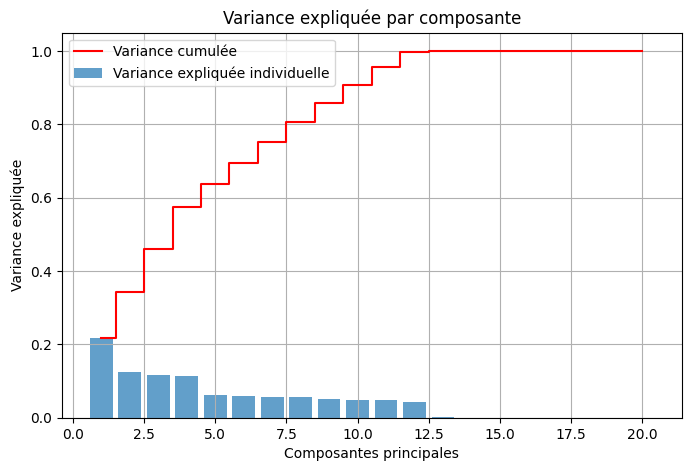

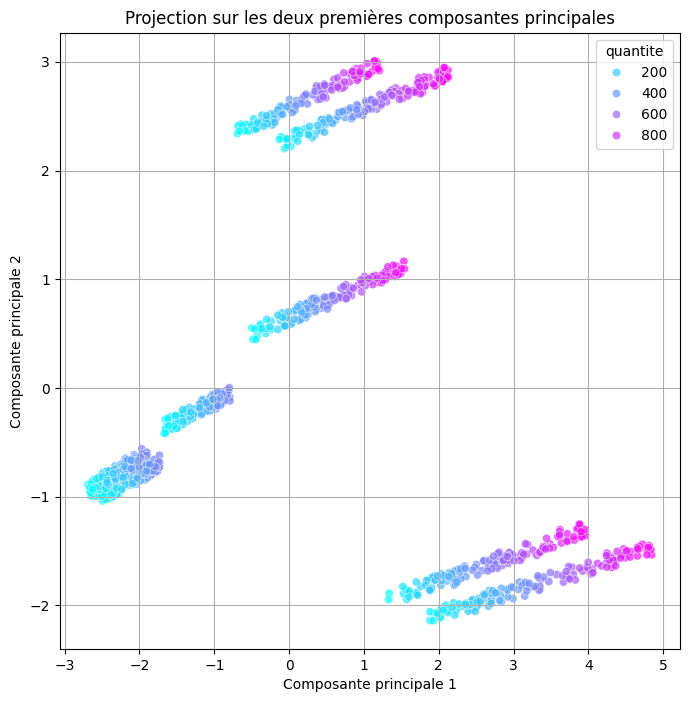

<Figure size 1000x800 with 0 Axes>

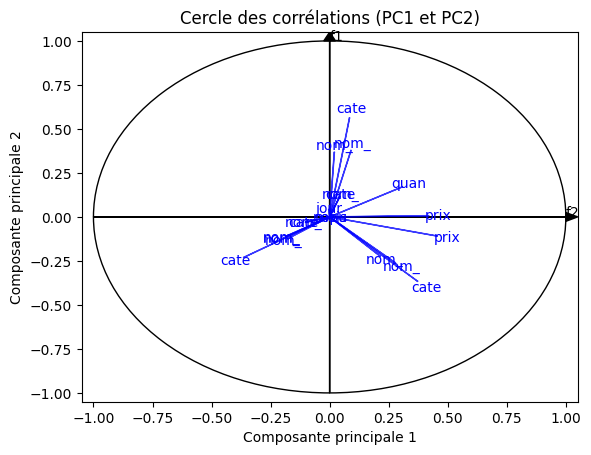

In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def analyse_acp_avancee(df):
    """
    Analyse en composantes principales (ACP) avec visualisations approfondies
    et interprétation des résultats.
    """
    # Sélection des variables explicatives
    features = [col for col in df.columns if col not in ['id','date_vente', 'date']]
    X = df[features]
    
    # Standardisation des données
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Application de l'ACP
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    
    # Variance expliquée
    explained_variance = pca.explained_variance_ratio_
    cumulated_variance = explained_variance.cumsum()
    
    # Graphique : Variance expliquée cumulée
    plt.figure(figsize=(8, 5))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, align='center', label='Variance expliquée individuelle')
    plt.step(range(1, len(cumulated_variance) + 1), cumulated_variance, where='mid', color='red', label='Variance cumulée')
    plt.title('Variance expliquée par composante')
    plt.xlabel('Composantes principales')
    plt.ylabel('Variance expliquée')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

    # Projection des données sur les deux premières composantes principales
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['quantite'], palette='cool', alpha=0.7)
    plt.title('Projection sur les deux premières composantes principales')
    plt.xlabel('Composante principale 1')
    plt.ylabel('Composante principale 2')
    plt.grid()
    plt.show()
    
    # Cercle des corrélations pour les deux premières composantes
    pcs = pd.DataFrame(pca.components_, columns=features, index=[f'PC{i+1}' for i in range(len(features))])
    plt.figure(figsize=(10, 8))
    fig, ax = plt.subplots()
    circle = plt.Circle((0,0), color='k', fill=False, radius=1)
    ax.add_artist(circle)
    ax.set_xlim(-1.05, 1.05)
    ax.set_ylim(-1.05, 1.05)
    ax.arrow(0, -1, 0, 2, head_width=0.05, head_length=0.05, fc='k', ec='k')
    ax.text(0, 1, 'f1', color='k')
    ax.arrow(-1, 0, 2, 0, head_width=0.05, head_length=0.05, fc='k', ec='k')
    ax.text(1, 0, 'f2', color='k')
    for i, feature in enumerate(features):
        ax.arrow(0, 0, pcs.iloc[0, i], pcs.iloc[1, i], color='b', alpha=0.75)
        ax.text(pcs.iloc[0, i]*1.1, pcs.iloc[1, i]*1.1, feature[:4], color='b', ha='center', va='center')
    plt.title("Cercle des corrélations (PC1 et PC2)")
    plt.xlabel("Composante principale 1")
    plt.ylabel("Composante principale 2")
    plt.show()

    return pca, X_pca, scaler, pcs

if 'df_ml' in locals():
    pca_model, X_pca, scaler_model, pcs = analyse_acp_avancee(df_ml)
